In [1]:
import numpy as np
from utils import Util
from rbm import RBM
from IPython.display import display

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# import pyspark packages
# set the kafka dependencies before create spark context or session
import os
# os.environ[
#     'PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.4,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.4 pyspark-shell'
from pyspark.sql import SparkSession, functions, types
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.appName('attraction').getOrCreate()
spark

In [4]:
# define path
ROOT_DIR = os.path.abspath('/home/hduser/document/jupyter/FYP/') 
tripad_attr_path = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/attractions/'
parquet_path = ROOT_DIR + '/crawler/datasets/tripadvisor_dataset/spark/'

In [5]:
epochs = 20
rows = 5000
alpha = 0.01
H = 128
batch_size = 8
free_energy = True

user = 1

In [6]:
util = Util()

attractions, ratings = util.read_data(
    spark, parquet_path + 'etl/attractions'), util.read_data(
        spark, parquet_path + 'etl/attraction_reviews')

Reading the data from /home/hduser/document/jupyter/FYP/crawler/datasets/tripadvisor_dataset/spark/etl/attractions
Reading the data from /home/hduser/document/jupyter/FYP/crawler/datasets/tripadvisor_dataset/spark/etl/attraction_reviews


In [11]:
ratings = util.clean_subset(ratings, rows)
num_vis = len(ratings)

Extracting 5000 rows from ratings


In [12]:
rbm_att, train = util.preprocess(ratings)

Preprocessing the dataset


In [17]:
valid = None
if free_energy:
    train, valid = util.split_data(train)

Free energy required, dividing into train and validation sets
Total size of the data is: 5000
Size of the training data is: 3750
Size of the validation data is: 1250


In [13]:
w = np.random.normal(loc=0, scale=0.01, size=[num_vis, H])

In [14]:
rbm = RBM(alpha, H, num_vis)

In [15]:
v = True

# Training

In [16]:
filename = "e" + str(epochs) + "_r" + str(rows) + "_lr" + str(
    alpha) + "_hu" + str(H) + "_bs" + str(batch_size)
filename

'e20_r5000_lr0.01_hu128_bs8'

Phase 1: Input Processing
Phase 2: Reconstruction
Creating the gradients
Running the session
Training RBM with 20 epochs and batch size: 8
Starting the training process
Error after 1 epochs is: 0.016684403643012047
Error after 2 epochs is: 0.0019795603584498167
Error after 3 epochs is: 0.0011653952533379197
Error after 4 epochs is: 0.0009123391937464476
Error after 5 epochs is: 0.0007355285924859345
Error after 6 epochs is: 0.0006711659370921552
Error after 7 epochs is: 0.0006220992072485387
Error after 8 epochs is: 0.0005780779174529016
Error after 9 epochs is: 0.0005336618633009493
Error after 10 epochs is: 0.0005216939025558531
Error after 11 epochs is: 0.0005195391713641584
Error after 12 epochs is: 0.0004918272024951875
Error after 13 epochs is: 0.00047666989848949015
Error after 14 epochs is: 0.00046391249634325504
Error after 15 epochs is: 0.0004660458362195641
Error after 16 epochs is: 0.00045589118963107467
Error after 17 epochs is: 0.0004384938511066139
Error after 18 epochs 

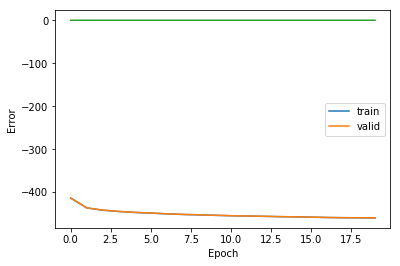

In [22]:
reco, prv_w, prv_vb, prv_hb = rbm.training(train, valid, user, epochs,
                                           batch_size, free_energy, v,
                                           filename)

In [17]:
filename

'e20_r5000_lr0.01_hu128_bs8'

In [18]:
reco_l, prv_w_l, prv_vb_l, prv_hb_l = rbm.load_predict(filename, train, user)

Model restored


In [24]:
if np.all(prv_w == prv_w_l) and np.all(prv_vb == prv_vb_l) and np.all(
        prv_hb == prv_hb_l):
    print("Model saved and loaded successfully")

Model saved and loaded successfully


In [25]:
unseen, seen = rbm.calculate_scores(ratings, attractions, reco_l, user)

,activityId,Recommendation Score
0,11449623,0.000139
1,11449646,0.000168
2,11449648,0.000152
3,11449649,0.000172
4,11449657,0.000105


In [26]:
rbm.export(unseen, seen, 'rbm_models/' + filename, str(user))